In [219]:
import json
import ast
import numpy as np
import pandas as pd

import spacy
import scispacy

import matplotlib.pyplot as plt

from pymedgraph.io.fetch_ncbi import NCBIFetcher
from pymedgraph.dataextraction.parser import parse_pubmed_article, get_pubmed_id

In [4]:
## define key terms
search_terms = ['phenylketonuria', 'tako-tsubo cardiomyopathy', 'lambert eaton syndrome']

# get abstracts

In [30]:
# init fetcher
fetcher = NCBIFetcher(email='soeren.spiegel@studium.uni-hamburg.de', tool_name='testNER', max_articles=250)

In [21]:
def fetch_abstracts(fetcher, term, n=100):
    paper_ids = list()
    abstracts = list()
    # do fetch
    records = fetcher.get_pubmed_paper(term, n)
    # get data from response
    for paper in records:
        paper_ids.append(get_pubmed_id(paper))
        abstracts.append(parse_pubmed_article(paper))
    
    # build df
    df = pd.DataFrame({'id': paper_ids, 'abstract': abstracts})
    df['term'] = term
    return df[['term', 'id', 'abstract']]

In [31]:
# get results and store in list
dfs = list()
for term in search_terms:
    dfs.append(fetch_abstracts(fetcher, term, 250))

In [35]:
# build df and store as csv
df = pd.concat(dfs)
df.to_csv('abstracts.csv', index=False, sep='|')

# NER

In [40]:
df = pd.read_csv('abstracts.csv', delimiter='|')
df.head(5)

,term,id,abstract
0,phenylketonuria,pubmed~33427303,Phenylketonuria Is An Inherited Disease For Wh...
1,phenylketonuria,pubmed~32482081,Vitamin B12 Deficiency Frequently Appears In P...
2,phenylketonuria,pubmed~34423658,Background Phenylketonuria Is The Most Common ...
3,phenylketonuria,pubmed~30778886,Phenylketonuria Is A Well-Known Rare Disease I...
4,phenylketonuria,pubmed~33093221,To Evaluate The Relationship Between Circulati...


In [39]:
df['term'].value_counts()

phenylketonuria              250
tako-tsubo cardiomyopathy    250
lambert eaton syndrome       249
Name: term, dtype: int64

In [47]:
df.groupby('term').agg({'abstract': lambda x: x.isna().sum()})

,abstract
term,
lambert eaton syndrome,43
phenylketonuria,4
tako-tsubo cardiomyopathy,75


In [ ]:
%%time
ddf = add_entities(df, 'en_core_sci_md')

In [121]:
ddf = pd.read_csv('abstracts_ents.csv', delimiter='|')

In [109]:
def add_entities(df, nlp_model):
    entities = list()
    nlp = spacy.load(nlp_model)
    docs = nlp.pipe(df['abstract'].fillna('').values)
    for doc in docs:
        entities.append([(e.text, e.label_) for e in doc.ents])
    df[nlp_model] = entities
    return df

In [122]:
%%time
for model in ['en_ner_craft_md', 'en_ner_jnlpba_md', 'en_ner_bc5cdr_md','en_ner_bionlp13cg_md']:
    print(f'processing {model}')
    ddf = add_entities(ddf, model)

processing en_ner_craft_md
processing en_ner_jnlpba_md
processing en_ner_bc5cdr_md
processing en_ner_bionlp13cg_md
CPU times: user 1min 44s, sys: 23.6 s, total: 2min 8s
Wall time: 2min 20s


In [380]:
ddf.head(2)

,term,id,abstract,en_core_sci_md,en_ner_craft_md,en_ner_jnlpba_md,en_ner_bc5cdr_md,en_ner_bionlp13cg_md
0,phenylketonuria,pubmed~33427303,Phenylketonuria Is An Inherited Disease For Wh...,"[('Phenylketonuria', 'no label'), ('Inherited ...","[(Amino Acid Phenylalanine, no label), (Amino ...",[],"[(Phenylketonuria, no label), (Inherited Disea...","[(Phenylketonuria, no label), (Amino Acid, no ..."
1,phenylketonuria,pubmed~32482081,Vitamin B12 Deficiency Frequently Appears In P...,"[('Vitamin B12 Deficiency', 'no label'), ('App...","[(Vitamin, no label), (Protein, no label), (Vi...","[(Vitamin B12, no label), (Serum Vitamin B12, ...","[(Vitamin B12, no label), (Phenylketonuria, no...","[(Vitamin B12, no label), (Phenylketonuria Pat..."


In [124]:
ddf.to_csv('abstracts_ents.csv', index=False, sep='|')

# analysis

In [252]:
models = ['en_core_sci_md', 'en_ner_craft_md', 'en_ner_jnlpba_md', 'en_ner_bc5cdr_md','en_ner_bionlp13cg_md']

## basic word count

In [130]:
ddf['term'].unique()

array(['phenylketonuria', 'tako-tsubo cardiomyopathy',
       'lambert eaton syndrome'], dtype=object)

In [184]:
n = 25

In [170]:
# build list with entities
def get_ents(df, model):
    ents = list()
    if model == 'en_core_sci_md':
        for i in df_term[model].values:
            ents += [e[0] for e in ast.literal_eval(i)]
    else:
        for i in df_term[model].values:
            ents += [e[0] for e in i]
    return ents
# dict for each model with entities
ent_dict = {m : get_ents(df_term, m) for m in models}

In [350]:
def get_model_exclusive_ents(df, model_name, models):
    unq_vals = df_ent[model_name].unique()
    print(f'unique vals for {model_name}: {len(unq_vals)}')
    all_other_entities = list()
    for model in models:
        if model != model_name:
            all_other_entities += list(df_ent[model].unique())
    print('count other entities:', len(all_other_entities))
    return [w for w in unq_vals if w not in all_other_entities]

In [257]:
def plot_ent_counts(model_1, ref_model, df):
    #ref_model = 'en_core_sci_md'
    #model_1 = 'en_ner_craft_md'

    fig, ax = plt.subplots(figsize=(14,8))

    # get value count
    ent_count = pd.Series(ent_dict[model_1]).value_counts()[:n]
    indx = list(ent_count.index)
    model1_vals = ent_count.values
    # get for reference model
    ref_count = pd.Series(ent_dict[ref_model])
    ref_count = ref_count[ref_count.isin(indx)].value_counts().reindex(indx).values

    # arange x axis
    X_axis = np.arange(len(indx))

    # plot
    plt.bar(X_axis - 0.2, model1_vals, 0.4, label = model_1)
    plt.bar(X_axis + 0.2, ref_count, 0.4, label = ref_model)

    plt.xticks(X_axis, indx, rotation=75)
    plt.title(f'{term} - {model_1}')
    plt.legend()
    return plt

In [338]:
def plot_marker(df, model_, color_dict):
    fig, ax = plt.subplots(figsize=(16,8))

    val_count = df[model_].value_counts()[:20]
    indx = list(val_count.index)

    ax.plot(val_count, marker='o', label=model_, color=model_colors[model_], linewidth=1.5, markersize=12)
    
    for model, color in color_dict.items():
        if model != model_:
            m_count = df[df[model].isin(indx)][model].value_counts().reindex(indx)
            ax.plot(m_count, marker='o', label=model, color=color, markersize=8, linestyle='None')
    plt.title(model_)
    plt.grid(True)
    plt.xticks(indx, rotation=75)
    plt.legend()
    return plt

### phenylketonuria

In [134]:
term = 'phenylketonuria'
df_term = ddf[ddf['term'] == term].copy()

In [271]:
for k in ent_dict:
    print(f'{k}: {len(ent_dict[k])}')

en_core_sci_md: 19940
en_ner_craft_md: 2556
en_ner_jnlpba_md: 383
en_ner_bc5cdr_md: 2478
en_ner_bionlp13cg_md: 4403


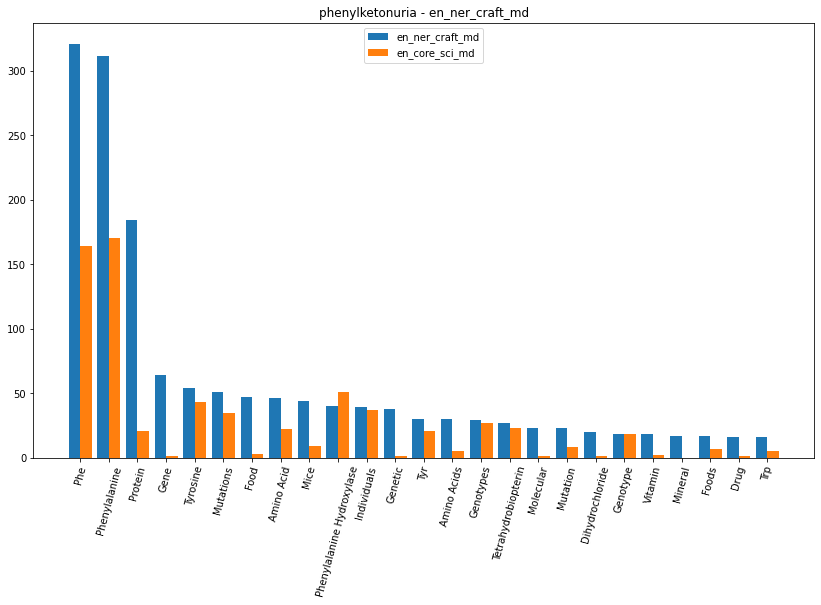

In [258]:
plot = plot_ent_counts('en_ner_craft_md', 'en_core_sci_md', ddf)
plot.show()

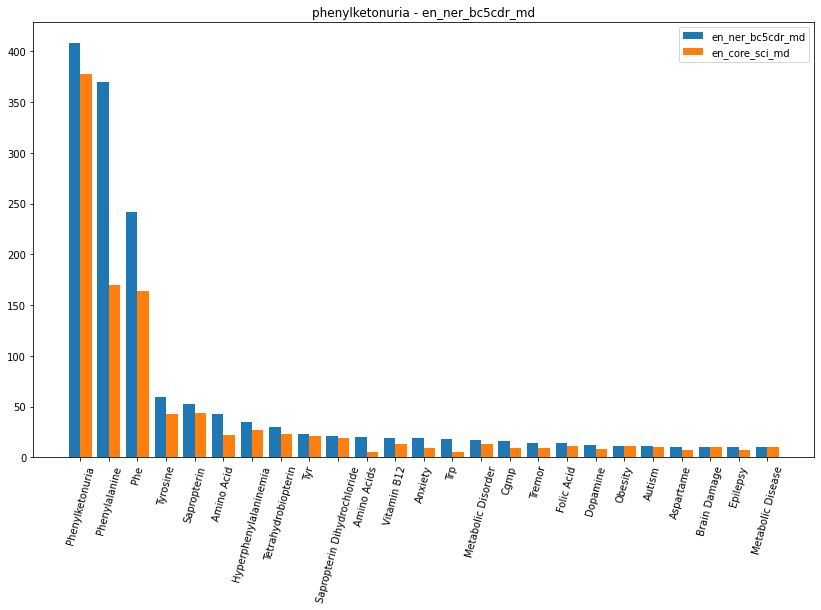

In [248]:
plot = plot_ent_counts('en_ner_bc5cdr_md', 'en_core_sci_md', ddf)
plot.show()

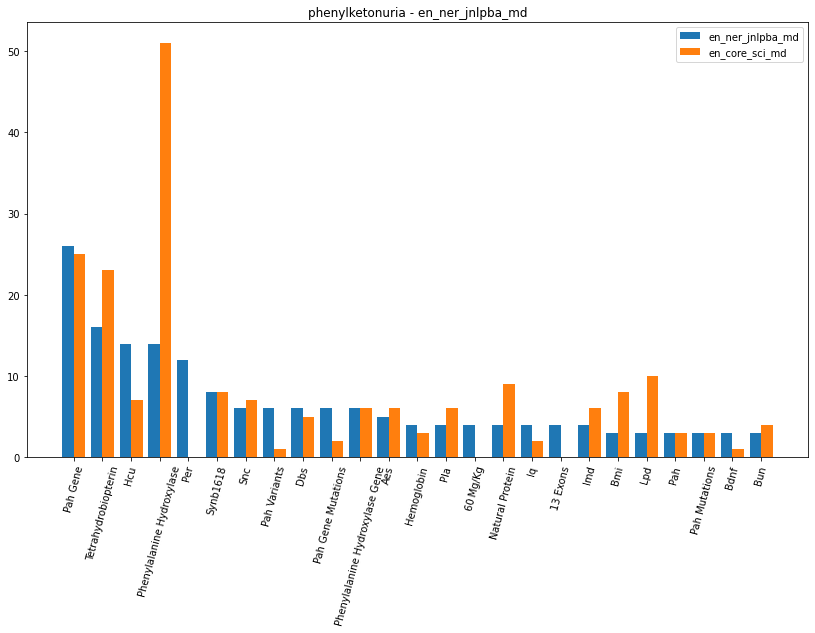

In [249]:
plot = plot_ent_counts('en_ner_jnlpba_md', 'en_core_sci_md', ddf)
plot.show()

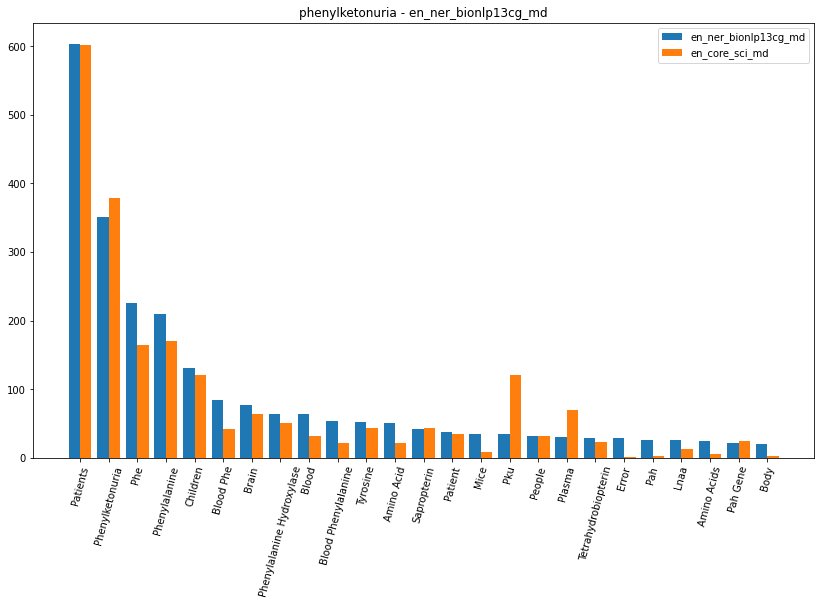

In [250]:
plot = plot_ent_counts('en_ner_bionlp13cg_md', 'en_core_sci_md', ddf)
plot.show()

In [285]:
model_colors = {k:v for k,v in zip(models, ['tab:orange', 'tab:blue', 'tab:green', 'tab:red', 'tab:cyan'])}
model_colors

{'en_core_sci_md': 'tab:orange',
 'en_ner_craft_md': 'tab:blue',
 'en_ner_jnlpba_md': 'tab:green',
 'en_ner_bc5cdr_md': 'tab:red',
 'en_ner_bionlp13cg_md': 'tab:cyan'}

In [286]:
# build df
df_ent = pd.DataFrame({ key:pd.Series(value) for key, value in ent_dict.items() })

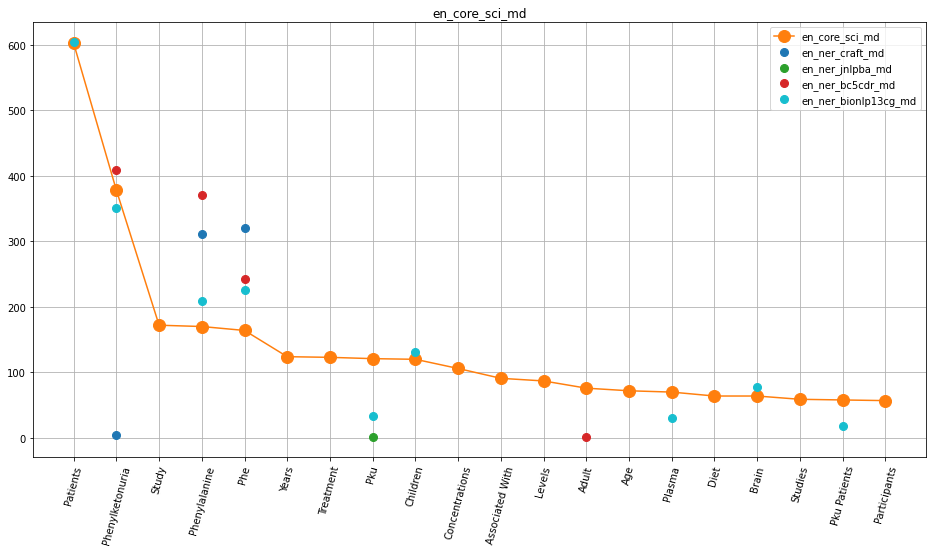

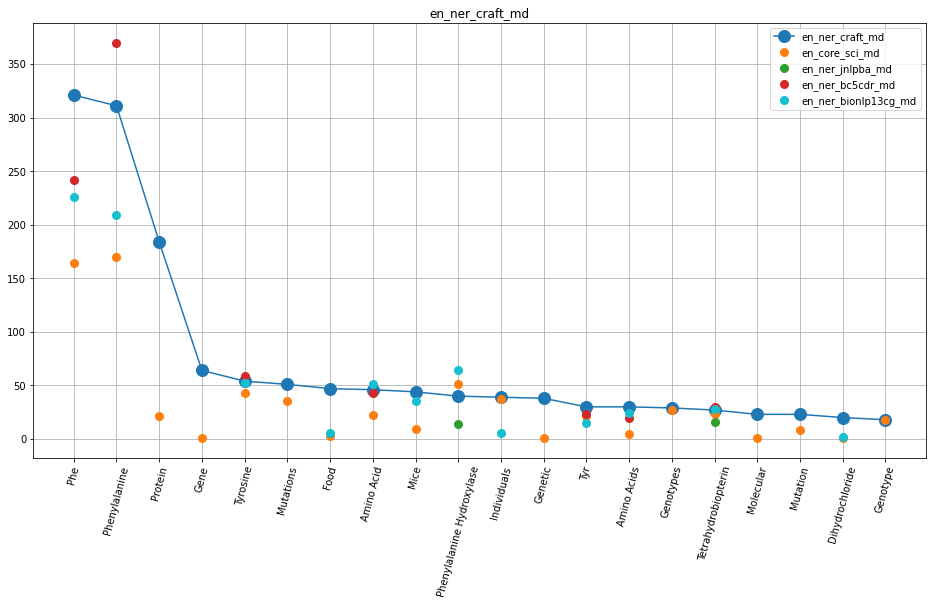

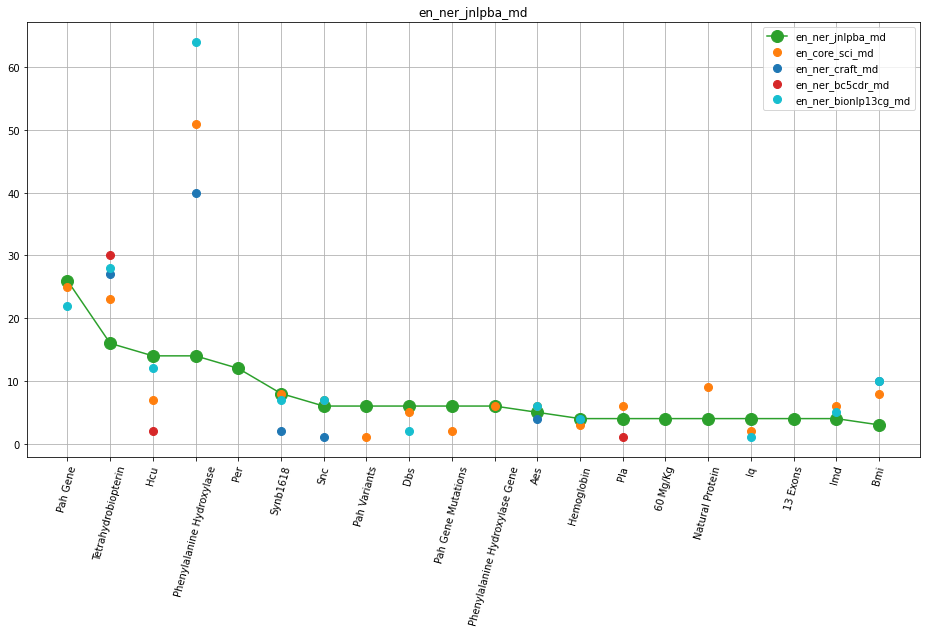

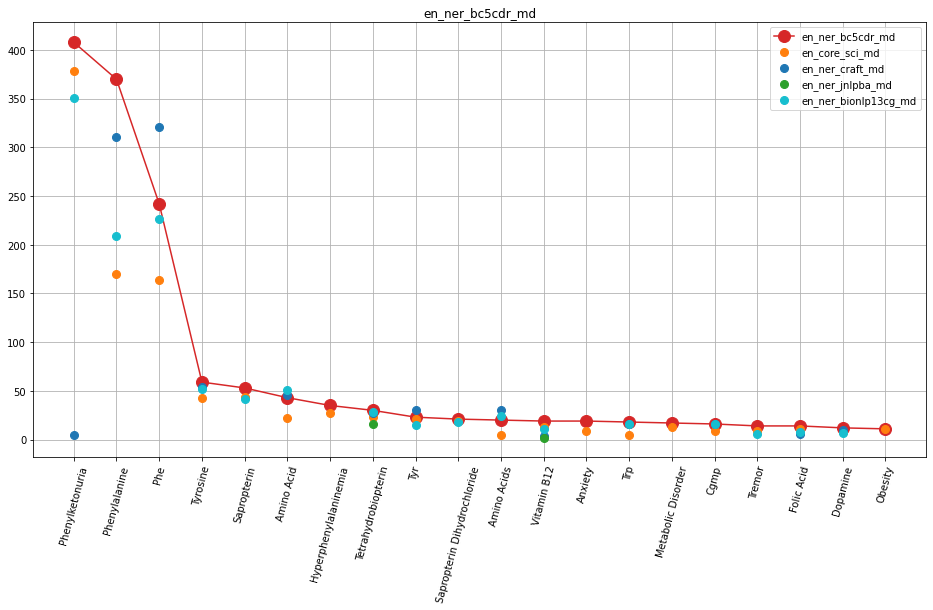

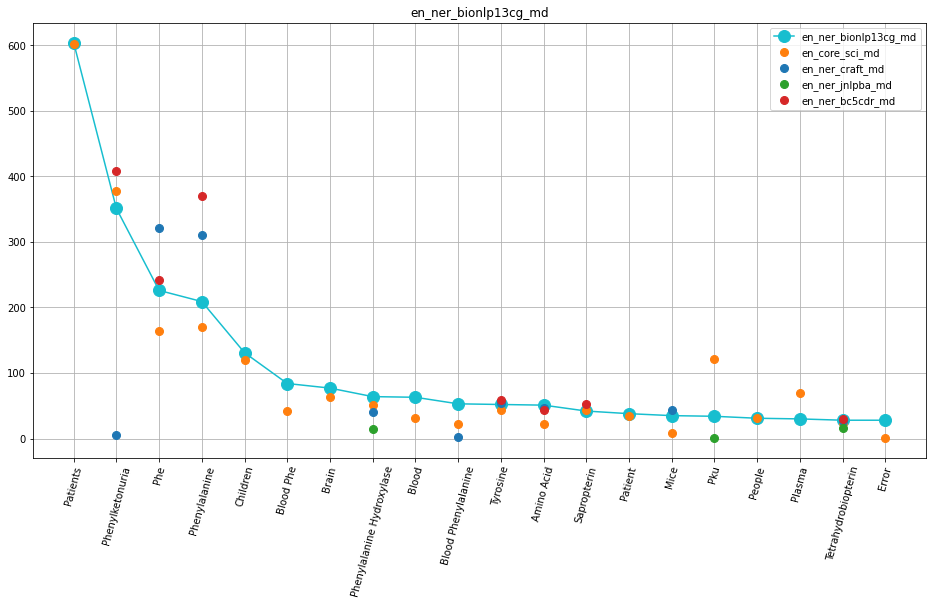

In [340]:
for m in models:
    plot = plot_marker(df_ent, m, model_colors)
    plot.show()

In [357]:
ex_ents_dict = dict()
for model in models:
    print(f'*********** {model} ********')
    ex_ents = get_model_exclusive_ents(df_ent, model, models)
    print('exclusive ents', len(ex_ents))
    ex_ents_dict[model] = ex_ents

*********** en_core_sci_md ********
unique vals for en_core_sci_md: 7375
count other entities: 2350
exclusive ents 6372
*********** en_ner_craft_md ********
unique vals for en_ner_craft_md: 477
count other entities: 9248
exclusive ents 109
*********** en_ner_jnlpba_md ********
unique vals for en_ner_jnlpba_md: 198
count other entities: 9527
exclusive ents 64
*********** en_ner_bc5cdr_md ********
unique vals for en_ner_bc5cdr_md: 588
count other entities: 9137
exclusive ents 163
*********** en_ner_bionlp13cg_md ********
unique vals for en_ner_bionlp13cg_md: 1087
count other entities: 8638
exclusive ents 441


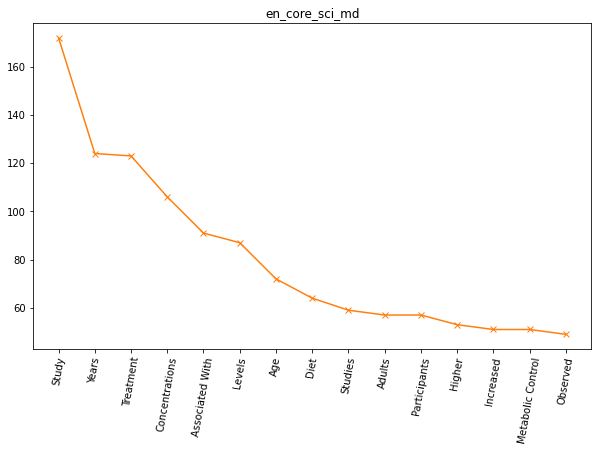

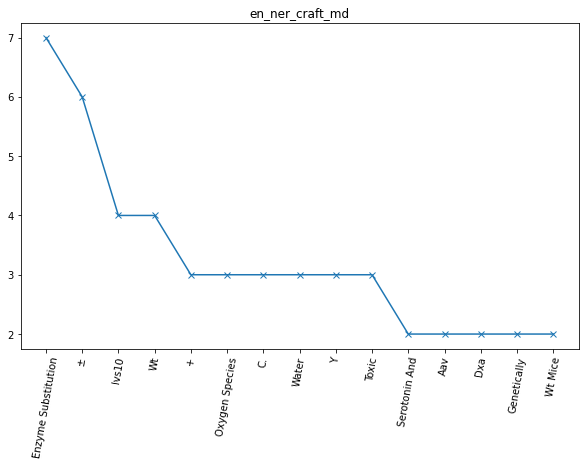

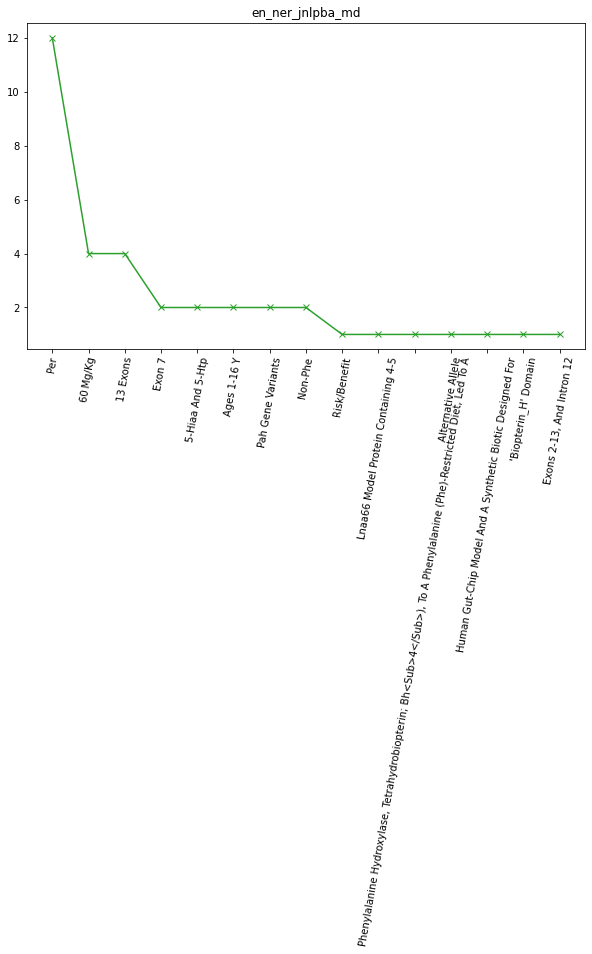

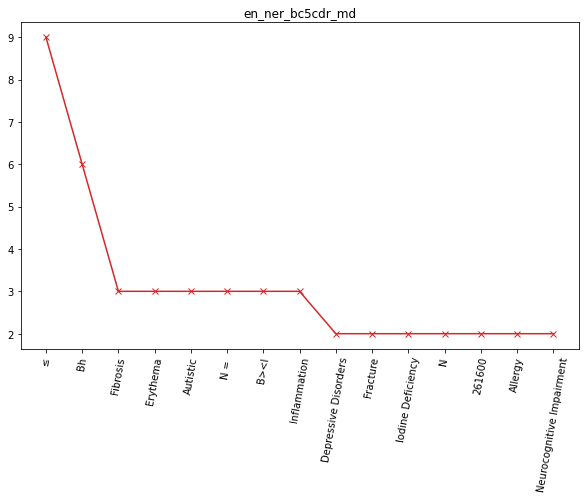

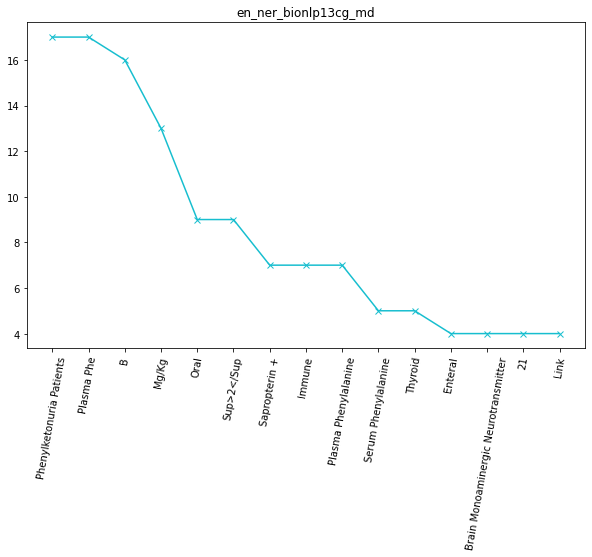

In [378]:
for model, entities in ex_ents_dict.items():
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(df_ent[df_ent[model].isin(entities)][model].value_counts()[:15], color=model_colors[model], marker='x')
    plt.xticks(rotation=80)
    plt.title(model)
    plt.show()

### tako-tsubo cardiomyopathy

In [381]:
term = 'tako-tsubo cardiomyopathy'
df_term = ddf[ddf['term'] == term].copy()

In [383]:
# dict for each model with entities
ent_dict = {m : get_ents(df_term, m) for m in models}
for k in ent_dict:
    print(f'{k}: {len(ent_dict[k])}')

en_core_sci_md: 9829
en_ner_craft_md: 465
en_ner_jnlpba_md: 144
en_ner_bc5cdr_md: 1742
en_ner_bionlp13cg_md: 2038


In [384]:
# build df
df_ent = pd.DataFrame({ key:pd.Series(value) for key, value in ent_dict.items() })

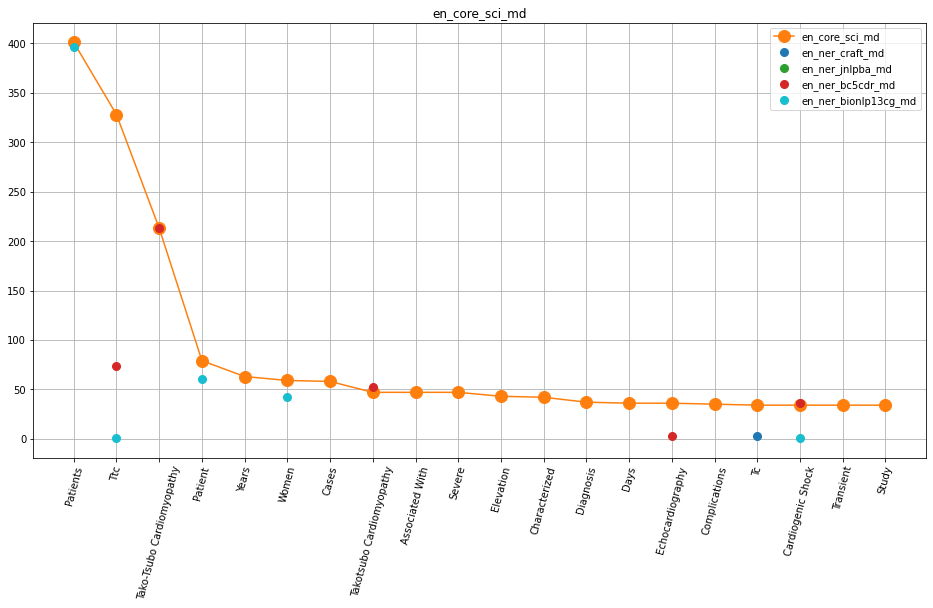

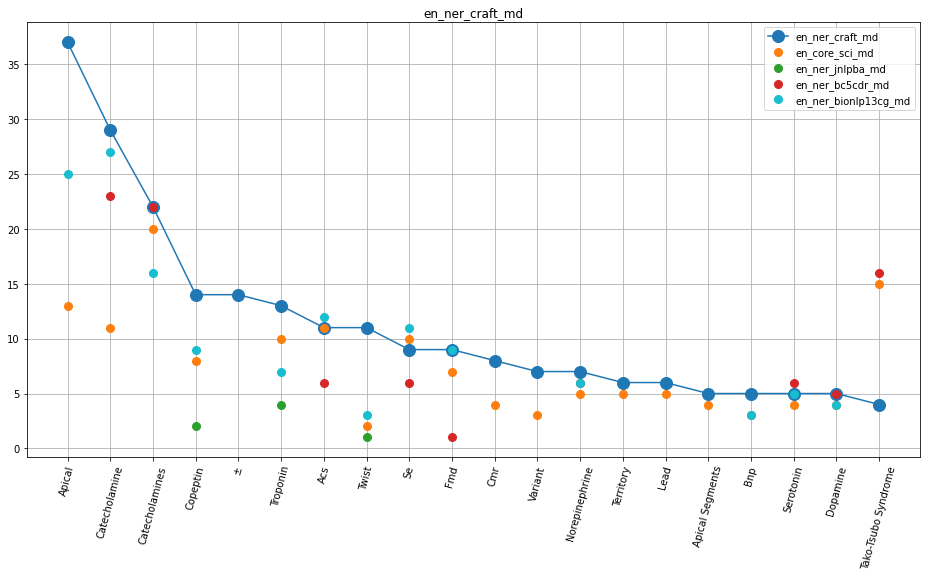

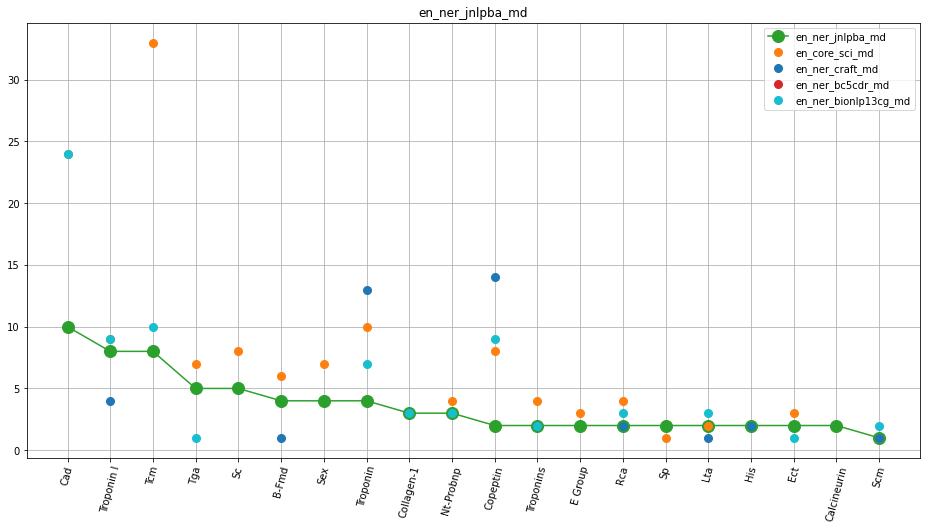

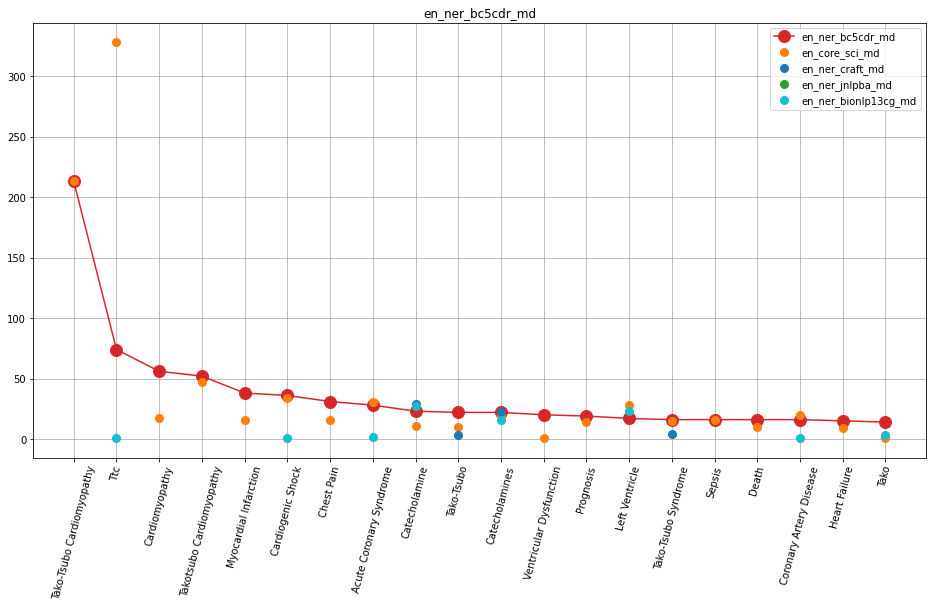

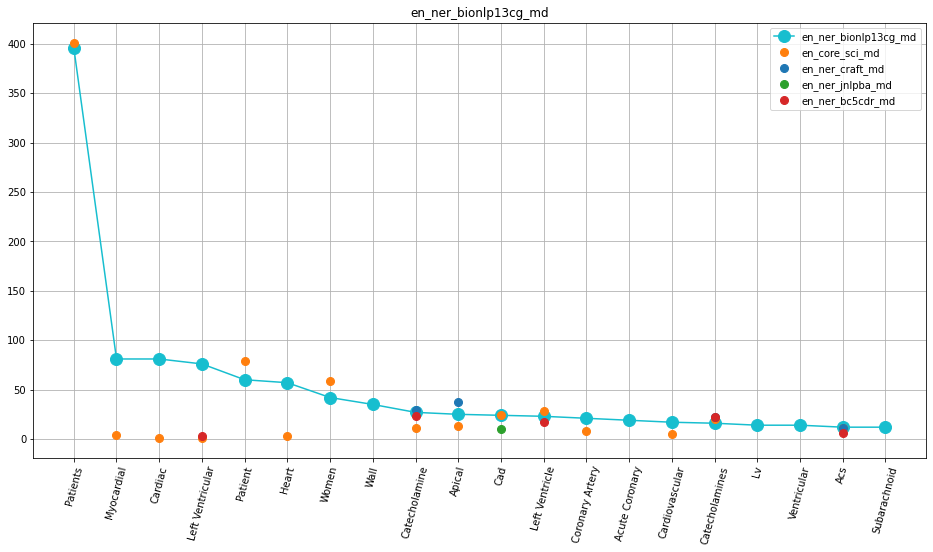

In [385]:
for m in models:
    plot = plot_marker(df_ent, m, model_colors)
    plot.show()

In [386]:
ex_ents_dict = dict()
for model in models:
    print(f'*********** {model} ********')
    ex_ents = get_model_exclusive_ents(df_ent, model, models)
    print('exclusive ents', len(ex_ents))
    ex_ents_dict[model] = ex_ents

*********** en_core_sci_md ********
unique vals for en_core_sci_md: 3852
count other entities: 1492
exclusive ents 3162
*********** en_ner_craft_md ********
unique vals for en_ner_craft_md: 162
count other entities: 5182
exclusive ents 44
*********** en_ner_jnlpba_md ********
unique vals for en_ner_jnlpba_md: 92
count other entities: 5252
exclusive ents 35
*********** en_ner_bc5cdr_md ********
unique vals for en_ner_bc5cdr_md: 613
count other entities: 4731
exclusive ents 193
*********** en_ner_bionlp13cg_md ********
unique vals for en_ner_bionlp13cg_md: 625
count other entities: 4719
exclusive ents 275


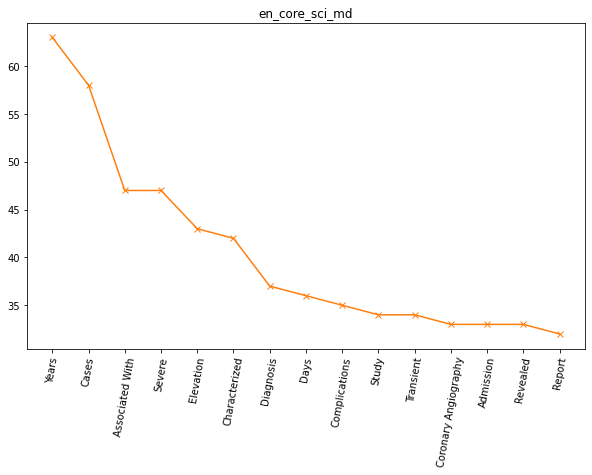

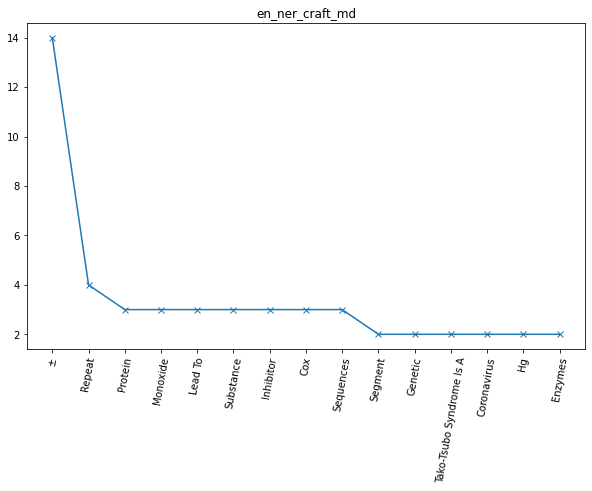

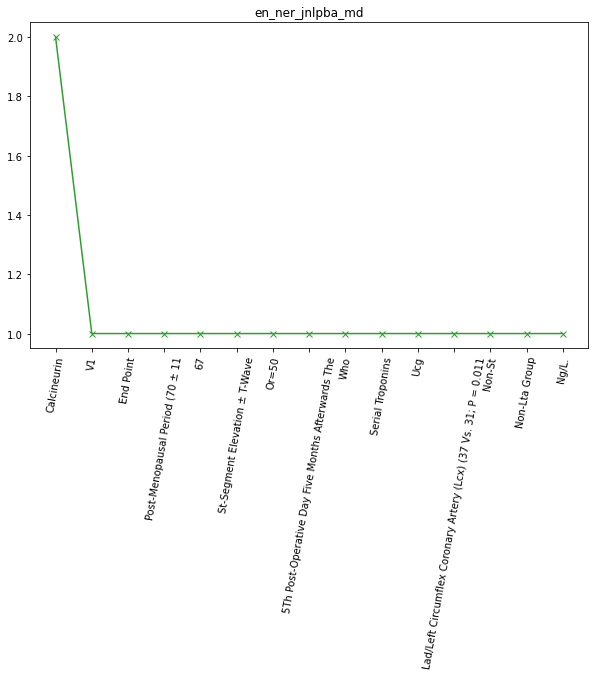

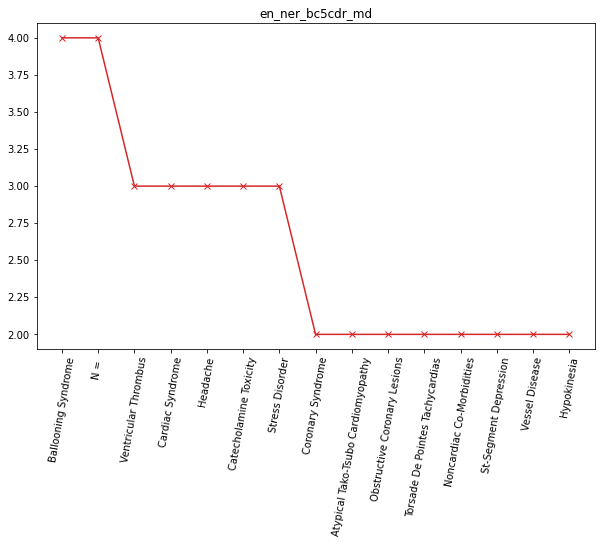

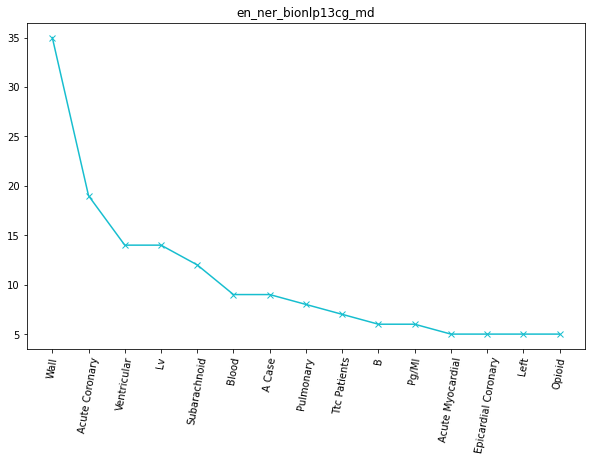

In [387]:
for model, entities in ex_ents_dict.items():
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(df_ent[df_ent[model].isin(entities)][model].value_counts()[:15], color=model_colors[model], marker='x')
    plt.xticks(rotation=80)
    plt.title(model)
    plt.show()

### lambert eaton syndrome

In [388]:
term = 'lambert eaton syndrome'
df_term = ddf[ddf['term'] == term].copy()

In [389]:
# dict for each model with entities
ent_dict = {m : get_ents(df_term, m) for m in models}
for k in ent_dict:
    print(f'{k}: {len(ent_dict[k])}')

en_core_sci_md: 11227
en_ner_craft_md: 974
en_ner_jnlpba_md: 331
en_ner_bc5cdr_md: 2102
en_ner_bionlp13cg_md: 3004


In [390]:
# build df
df_ent = pd.DataFrame({ key:pd.Series(value) for key, value in ent_dict.items() })

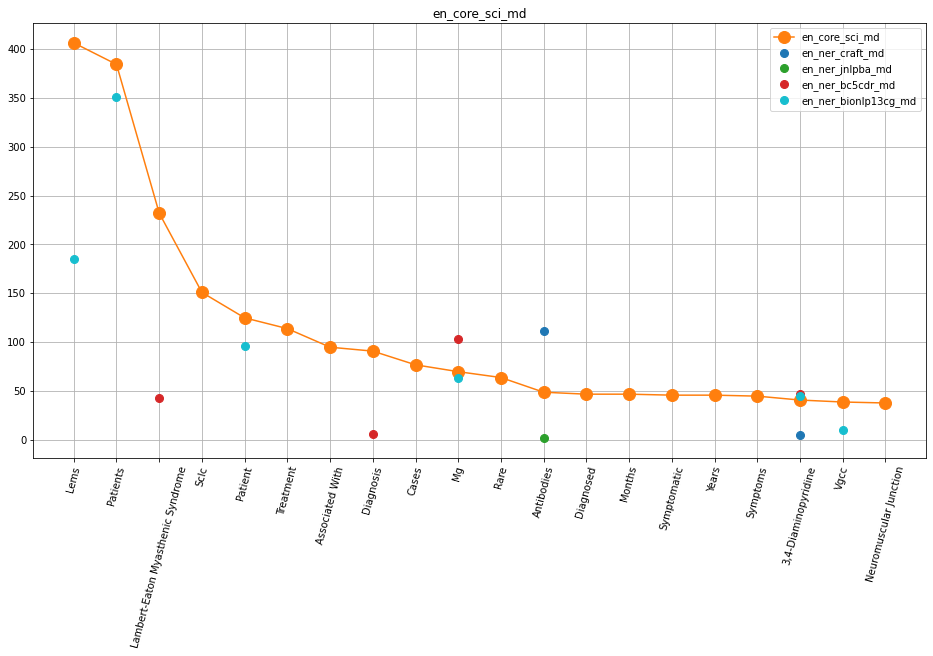

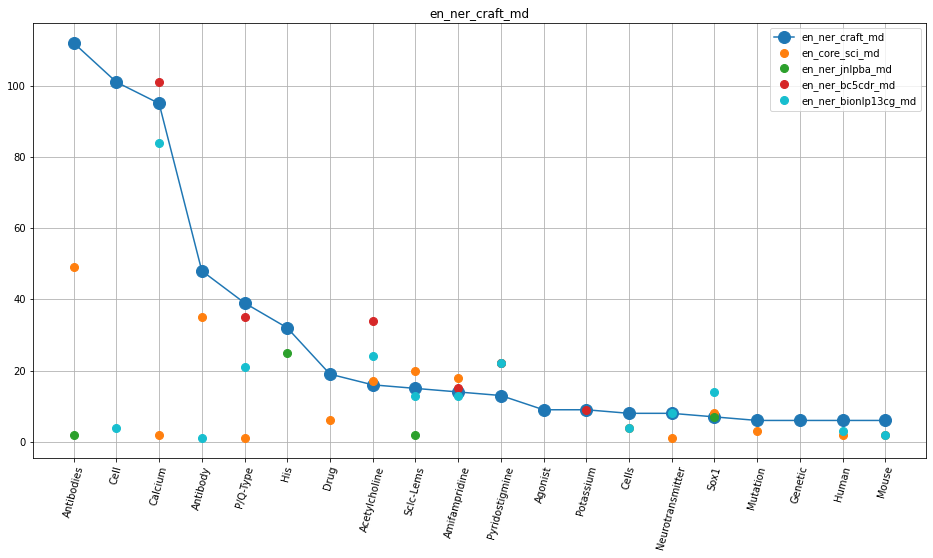

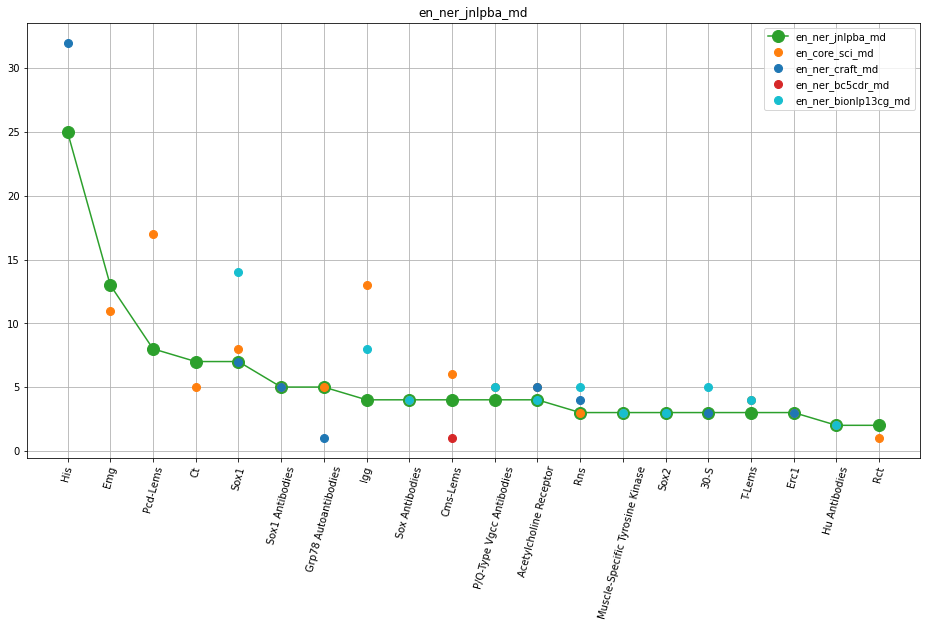

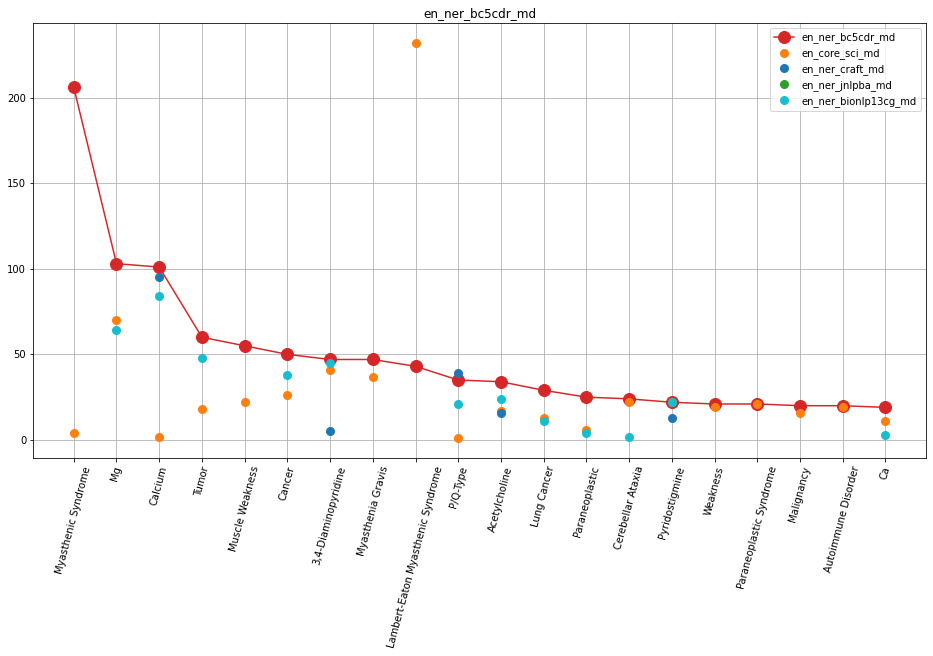

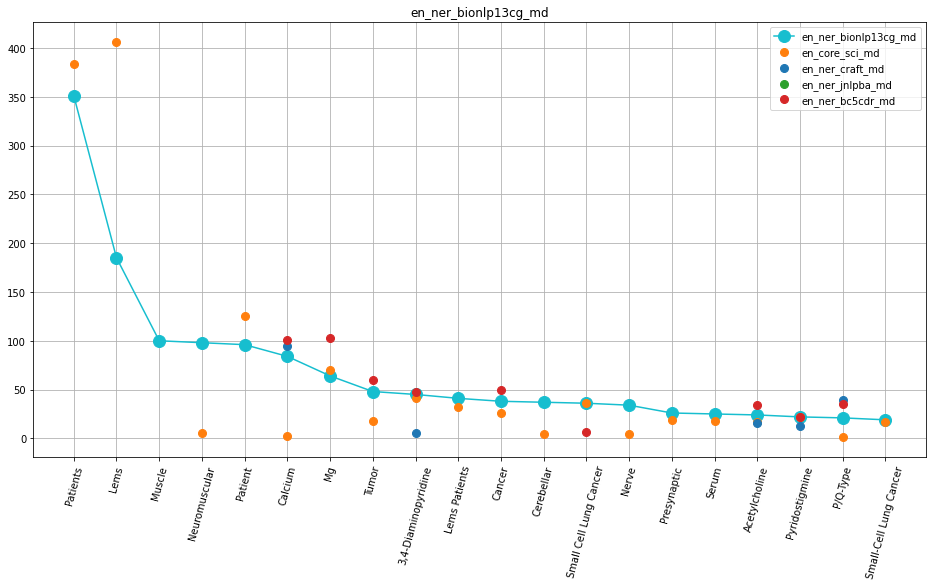

In [391]:
for m in models:
    plot = plot_marker(df_ent, m, model_colors)
    plot.show()

In [392]:
ex_ents_dict = dict()
for model in models:
    print(f'*********** {model} ********')
    ex_ents = get_model_exclusive_ents(df_ent, model, models)
    print('exclusive ents', len(ex_ents))
    ex_ents_dict[model] = ex_ents

*********** en_core_sci_md ********
unique vals for en_core_sci_md: 4294
count other entities: 1922
exclusive ents 3425
*********** en_ner_craft_md ********
unique vals for en_ner_craft_md: 262
count other entities: 5954
exclusive ents 61
*********** en_ner_jnlpba_md ********
unique vals for en_ner_jnlpba_md: 214
count other entities: 6002
exclusive ents 64
*********** en_ner_bc5cdr_md ********
unique vals for en_ner_bc5cdr_md: 573
count other entities: 5643
exclusive ents 154
*********** en_ner_bionlp13cg_md ********
unique vals for en_ner_bionlp13cg_md: 873
count other entities: 5343
exclusive ents 340


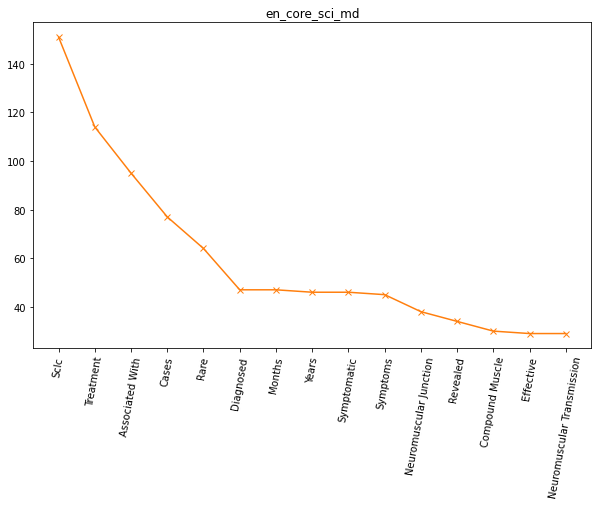

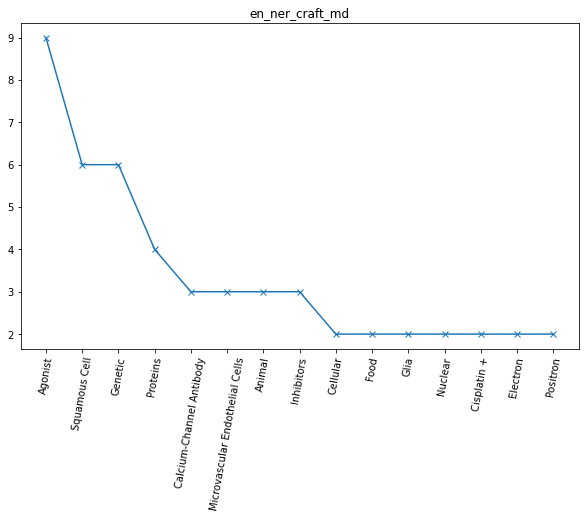

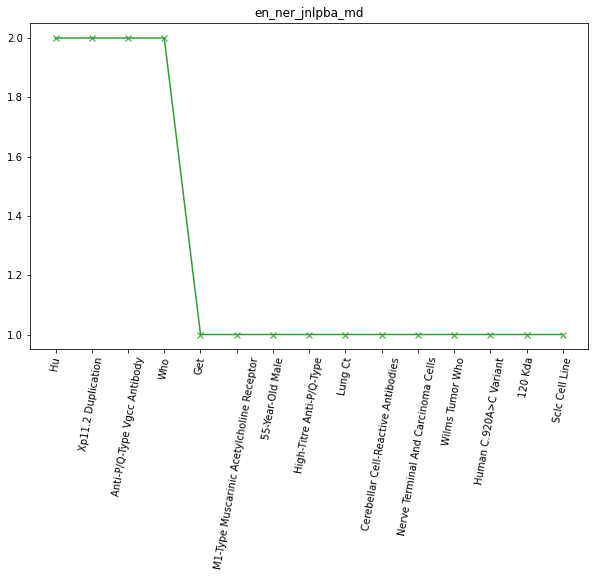

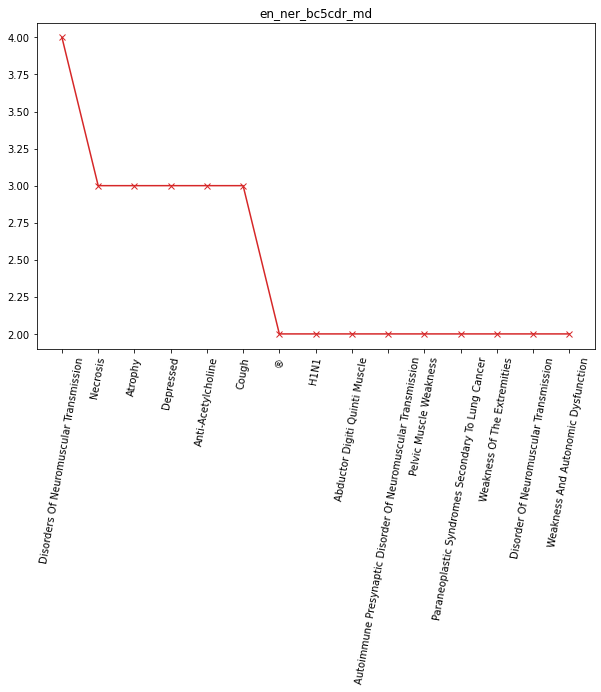

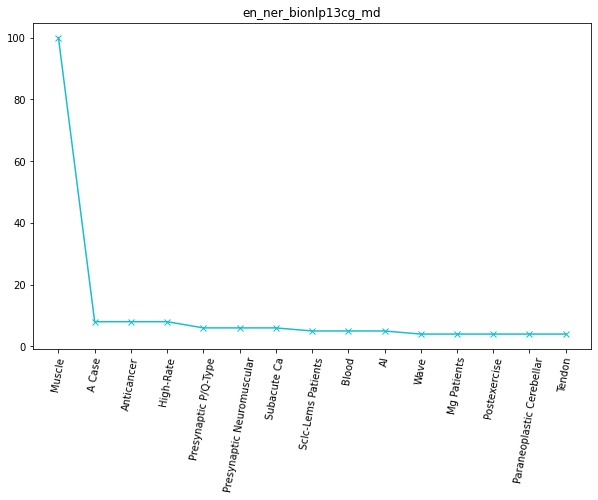

In [393]:
for model, entities in ex_ents_dict.items():
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(df_ent[df_ent[model].isin(entities)][model].value_counts()[:15], color=model_colors[model], marker='x')
    plt.xticks(rotation=80)
    plt.title(model)
    plt.show()